# Analysis Notebook for Template Technology

In [1]:
import os
import sys

import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb

sys.path.insert(0, os.path.abspath("../../../src"))

import tyche             as ty

## Load data

In [2]:
designs = ty.Designs(path = '.',
                     name = 'template.xlsx')
investments = ty.Investments(path = '.',
                             name = 'template.xlsx')

### Compile the production and metric functions for each technology in the dataset.

In [3]:
designs.compile()

## Evaluate the scenarios in the dataset.

In [4]:
scenario_results = designs.evaluate_scenarios(sample_count=100)

Evaluating Technology A
Evaluating Technology M


In [5]:
scenario_results.xs(1, level="Sample", drop_level=False)

Value  \
Technology   Scenario                     Sample Variable Index                               
Technology A All Components Fast Progress 1      Cost     Cost                629692.029116   
                                                 Metric   Environment             16.456869   
                                                          Labor                    3.039084   
                                                          Overall Efficiency       0.386686   
                                                          System Cost          84655.542349   
...                                                                                     ...   
Technology M Peripherals Slow Progress    1      Metric   Overall Efficiency       0.436349   
                                                          System Cost          58221.852545   
                                                 Output   Output F                27.053650   
                                                          Output G                10.226086   
                                                          Output P                15.455981   

                                                                                                     Units  
Technology   Scenario                     Sample Variable Index                                             
Technology A All Components Fast Progress 1      Cost     Cost                                  USD/system  
                                                 Metric   Environment                    delta unit/system  
                                                          Labor                           delta USD/system  
                                                          Overall Efficiency                      unitless  
                                                          System Cost         delta USD/system, annualized  
...                                                                                                    ...  
Technology M Peripherals Slow Progress    1      Metric   Overall Efficiency                      unitless  
                                                          System Cost         delta USD/system, annualized  
                                                 Output   Output F                               mass/year  
                                                          Output G                               mass/year  
                                                          Output P                               mass/year  

[160 rows x 2 columns]

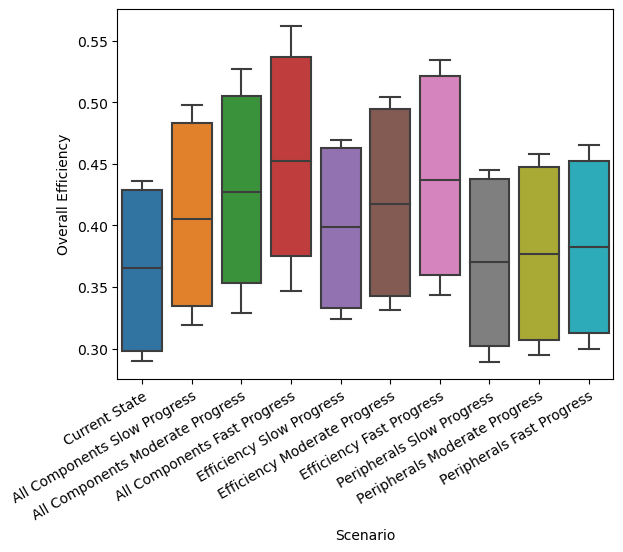

In [6]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ("Metric", "Overall Efficiency"),
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Overall Efficiency")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

[Text(0, 0, 'Current State'),
 Text(1, 0, 'All Components Slow Progress'),
 Text(2, 0, 'All Components Moderate Progress'),
 Text(3, 0, 'All Components Fast Progress'),
 Text(4, 0, 'Efficiency Slow Progress'),
 Text(5, 0, 'Efficiency Moderate Progress'),
 Text(6, 0, 'Efficiency Fast Progress'),
 Text(7, 0, 'Peripherals Slow Progress'),
 Text(8, 0, 'Peripherals Moderate Progress'),
 Text(9, 0, 'Peripherals Fast Progress')]

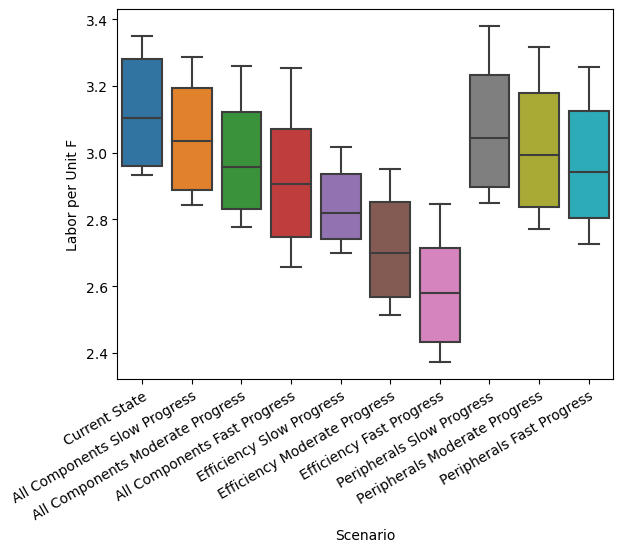

In [7]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ("Metric", "Labor"),
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Labor per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

[Text(0, 0, 'Current State'),
 Text(1, 0, 'All Components Slow Progress'),
 Text(2, 0, 'All Components Moderate Progress'),
 Text(3, 0, 'All Components Fast Progress'),
 Text(4, 0, 'Efficiency Slow Progress'),
 Text(5, 0, 'Efficiency Moderate Progress'),
 Text(6, 0, 'Efficiency Fast Progress'),
 Text(7, 0, 'Peripherals Slow Progress'),
 Text(8, 0, 'Peripherals Moderate Progress'),
 Text(9, 0, 'Peripherals Fast Progress')]

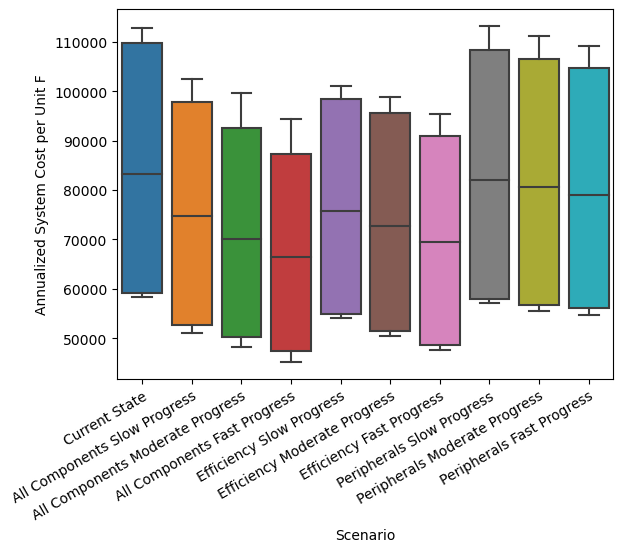

In [8]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ("Metric", "System Cost"),
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Annualized System Cost per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

[Text(0, 0, 'Current State'),
 Text(1, 0, 'All Components Slow Progress'),
 Text(2, 0, 'All Components Moderate Progress'),
 Text(3, 0, 'All Components Fast Progress'),
 Text(4, 0, 'Efficiency Slow Progress'),
 Text(5, 0, 'Efficiency Moderate Progress'),
 Text(6, 0, 'Efficiency Fast Progress'),
 Text(7, 0, 'Peripherals Slow Progress'),
 Text(8, 0, 'Peripherals Moderate Progress'),
 Text(9, 0, 'Peripherals Fast Progress')]

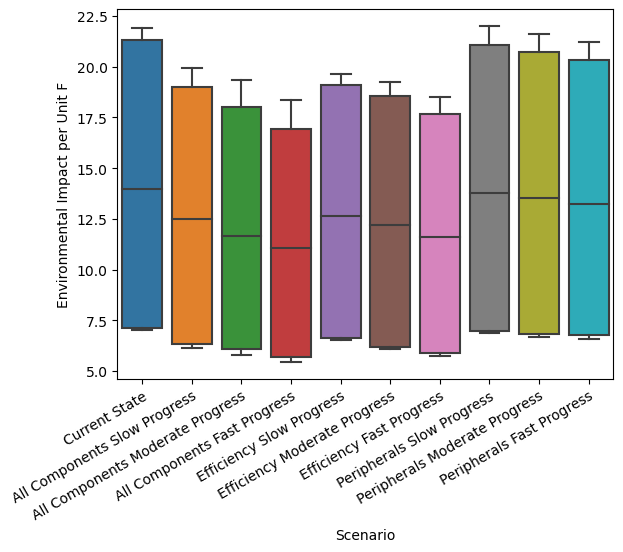

In [9]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ("Metric", "Environment"),
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Environmental Impact per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

## Evaluate the investments in the dataset.

In [20]:
investment_results = investments.evaluate_investments(designs, sample_count=100)

Evaluating Technology A
Evaluating Technology M
Evaluating Technology A
Evaluating Technology M


### Costs of investments - these calculations are not set up correctly

In [21]:
investment_results.amounts

,Amount
Investment,
"High Budget, All Categories",3500000300000025000003000000350000025000002250000
"High Budget, Components Only",3500000300000025000003000000350000000
"Low Budget, All Categories",1500000125000010000001000000175000015000001250000
"Low Budget, Components Only",1500000125000010000001000000175000000
"Medium Budget, All Categories",1800000100000012000002000000250000020000001750000
"Medium Budget, Components Only",1800000100000012000002000000250000000


### Benefits of investments.

In [22]:
investment_results.metrics.xs(1, level="Sample", drop_level=False)

Value  \
Investment                  Category                 Tranche                   Scenario                     Sample Technology   Index                               
High Budget, All Categories Research on Component B0 Component B0 High Funding All Components Fast Progress 1      Technology A Environment             17.006701   
                                                                                                                                Labor                    3.050429   
                                                                                                                                Overall Efficiency       0.374184   
                                                                                                                                System Cost          87483.926656   
                                                                                                                   Technology M Environment              5.700505   
...                                                                                                                                                           ...   
Low Budget, All Categories  Research on Peripherals  Peripherals Low Funding   Peripherals Slow Progress    1      Technology A System Cost         112051.691106   
                                                                                                                   Technology M Environment              7.070948   
                                                                                                                                Labor                    2.927551   
                                                                                                                                Overall Efficiency       0.433395   
                                                                                                                                System Cost          58618.662063   

                                                                                                                                                                           Units  
Investment                  Category                 Tranche                   Scenario                     Sample Technology   Index                                             
High Budget, All Categories Research on Component B0 Component B0 High Funding All Components Fast Progress 1      Technology A Environment                    delta unit/system  
                                                                                                                                Labor                           delta USD/system  
                                                                                                                                Overall Efficiency                      unitless  
                                                                                                                                System Cost         delta USD/system, annualized  
                                                                                                                   Technology M Environment                    delta unit/system  
...                                                                                                                                                                          ...  
Low Budget, All Categories  Research on Peripherals  Peripherals Low Funding   Peripherals Slow Progress    1      Technology A System Cost         delta USD/system, annualized  
                                                                                                                   Technology M Environment                    delta unit/system  
                                                                                                                                Labor                           delta USD/system  
                                         

In [13]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value  \
Investment                     Technology   Sample Index                               
High Budget, All Categories    Technology A 1      Environment            128.021304   
                                                   Labor                   21.487785   
                                                   Overall Efficiency       2.437971   
                                                   System Cost         658552.560160   
                               Technology M 1      Environment             40.814610   
                                                   Labor                   18.988098   
                                                   Overall Efficiency       3.694093   
                                                   System Cost         338356.036557   
High Budget, Components Only   Technology A 1      Environment            133.619717   
                                                   Labor                   22.307788   
                                                   Overall Efficiency       2.348254   
                                                   System Cost         687351.275710   
                               Technology M 1      Environment             42.251975   
                                                   Labor                   19.601129   
                                                   Overall Efficiency       3.592968   
                                                   System Cost         350271.897503   
Low Budget, All Categories     Technology A 1      Environment            135.509937   
                                                   Labor                   22.132017   
                                                   Overall Efficiency       2.304465   
                                                   System Cost         697074.732448   
                               Technology M 1      Environment             45.628172   
                                                   Labor                   20.140883   
                                                   Overall Efficiency       3.294877   
                                                   System Cost         378260.809373   
Low Budget, Components Only    Technology A 1      Environment            138.042143   
                                                   Labor                   22.481146   
                                                   Overall Efficiency       2.266347   
                                                   System Cost         710100.614501   
                               Technology M 1      Environment             46.093071   
                                                   Labor                   20.351289   
                                                   Overall Efficiency       3.264881   
                                                   System Cost         382114.858874   
Medium Budget, All Categories  Technology A 1      Environment            129.428966   
                                                   Labor                   21.801790   
                                                   Overall Efficiency       2.413020   
                                                   System Cost         665793.692864   
                               Technology M 1      Environment             43.541695   
                                                   Labor                   19.384724   
                                                   Overall Efficiency       3.454450   
                                                   System Cost         360963.768314   
Medium Budget, Components Only Technology A 1      Environment            133.802532   
                                                   Labor                   22.433694   
                                                   Overall Efficiency       2.344710   
                                                   System Cost         688291.691068   
                               

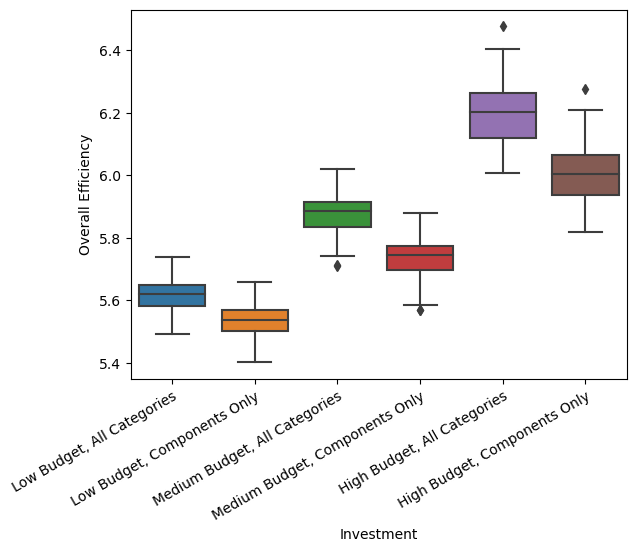

In [23]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Overall Efficiency",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Overall Efficiency")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

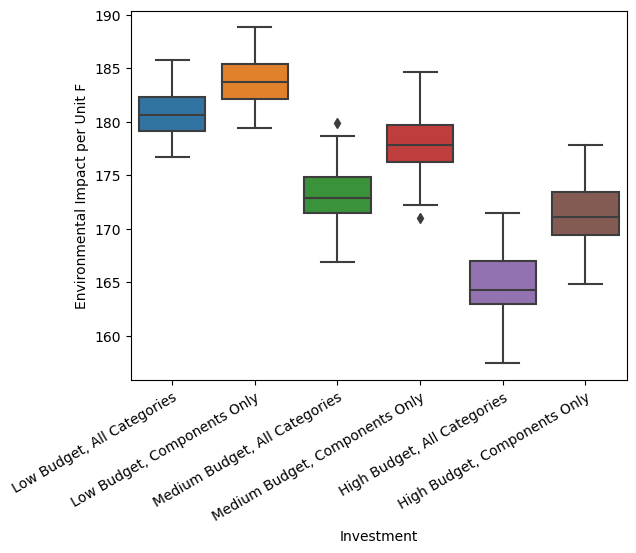

In [24]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Environment",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Environmental Impact per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

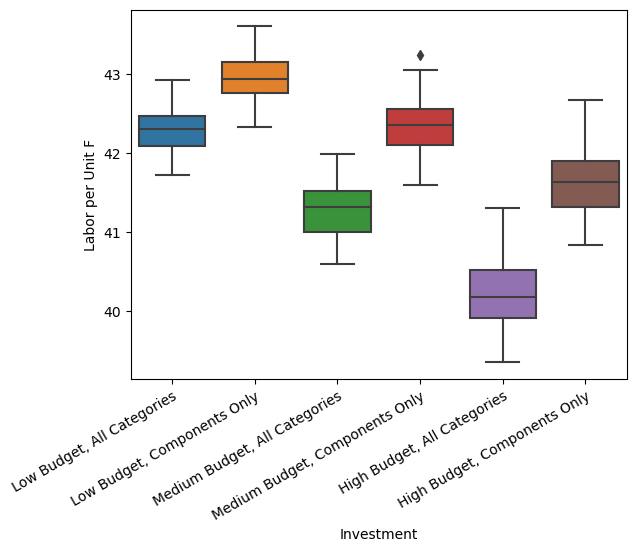

In [25]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Labor",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Labor per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

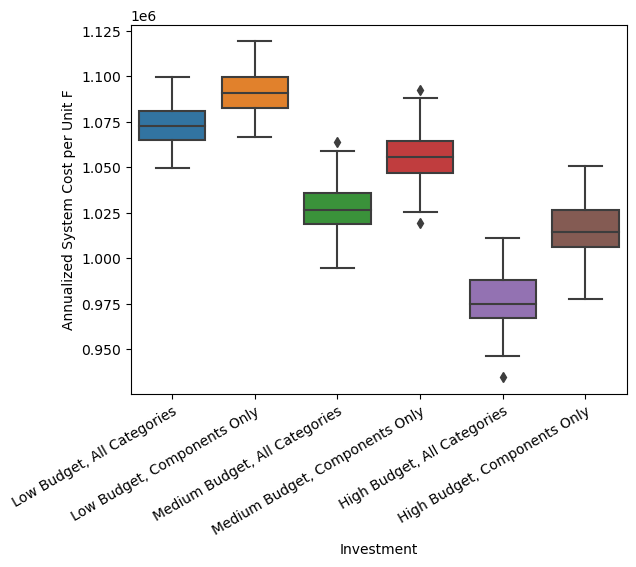

In [26]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "System Cost",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Annualized System Cost per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

## Multi-objective decision analysis.

### Compute costs and metrics for tranches.

Tranches are atomic units for building investment portfolios. Evaluate all of the tranches, so we can assemble them into investments (portfolios).

In [ ]:
tranche_results = investments.evaluate_tranches(designs, sample_count=50)

Display the cost of each tranche.

In [ ]:
tranche_results.amounts

Display the metrics for each tranche.

In [ ]:
tranche_results.summary

Save the results.

In [ ]:
#tranche_results.amounts.to_csv("example-tranche-amounts.csv")
#tranche_results.summary.to_csv("example-tranche-summary.csv")

### Fit a response surface to the results.

The response surface interpolates between the discrete set of cases provided in the expert elicitation. This allows us to study funding levels intermediate between those scenarios.

In [ ]:
evaluator = ty.Evaluator(tranche_results)

Here are the categories of investment and the maximum amount that could be invested in each:

In [ ]:
evaluator.max_amount

Here are the metrics and their units of measure:

In [ ]:
evaluator.units

#### Example interpolation.

Let's evaluate the case where each category is invested in at half of its maximum amount.

In [ ]:
example_investments = evaluator.max_amount / 2
example_investments

In [ ]:
evaluator.evaluate(example_investments)

Let's evaluate the mean instead of outputing the whole distribution.

In [ ]:
evaluator.evaluate_statistic(example_investments, np.mean)

Here is the standard deviation:

In [ ]:
evaluator.evaluate_statistic(example_investments, np.std)

A risk-averse decision maker might be interested in the 10% percentile:

In [ ]:
evaluator.evaluate_statistic(example_investments, lambda x: np.quantile(x, 0.1))

### ε-Constraint multiobjective optimization

In [ ]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

In order to meaningfully map the decision space, we need to know the maximum values for each of the metrics.

#### Example optimization.

Limit spending to $3M.

In [ ]:
investment_max = 3e6

Require that the GHG reduction be at least 40 gCO2e/system and that the Labor wages not decrease.

In [ ]:
metric_min = pd.Series([40, 0], name = "Value", index = ["GHG", "Labor"])
metric_min

Compute the ε-constrained maximum for the LCOE.

In [ ]:
optimum = optimizer.opt_slsqp(
    "LCOE"                       ,
    sense = 'max',
    total_amount = investment_max,
    statistic    = np.mean       ,
)
optimum.exit_message

Here are the optimal spending levels:

In [ ]:
np.round(optimum.amounts)

Here are the three metrics at that optimum:

In [ ]:
optimum.metrics

*Thus, by putting all of the investment into Module R&D, we can expected to achieve a mean 3.75 ¢/kWh reduction in LCOE under the GHG and Labor constraints.*

It turns out that there is no solution for these constraints if we evaluate the 10th percentile of the metrics, for a risk-averse decision maker.

In [ ]:
optimum = optimizer.opt_slsqp(
    "LCOE"                       ,
    sense = 'max',
    total_amount = investment_max,
    statistic    = lambda x: np.quantile(x, 0.1),
)
optimum.exit_message

Let's try again, but with a less stringent set of constraints, only constraining GHG somewhat  but not Labor at all.

In [ ]:
optimum = optimizer.opt_slsqp(
    "LCOE"                                                         ,
    sense = 'max',
    total_amount = investment_max                                  ,
    statistic    = lambda x: np.quantile(x, 0.1)                  ,
)
optimum.exit_message

In [ ]:
np.round(optimum.amounts)

In [ ]:
optimum.metrics

## Reproducing GUI optimization for Git issue 99
See: https://github.com/NREL/tyche/issues/99

### Example MILP optimization

This formulation converts the original non-linear optimization into a piecewise linear, mixed-integer optimization, and then attempts to solve the same problem.

~~As written, the MILP formulation is infeasible.~~

In [ ]:
investment_max = 3e6
metric_min = pd.Series([40, 0], name = "Value", index = ["GHG", "Labor"])

optimum = optimizer.opt_milp(
    "LCOE"                       ,
    sense = 'max',
    total_amount = investment_max,
    statistic    = np.mean       ,
)

optimum.exit_message

Let's determine if the problem is truly infeasible or if the solver is failing by examining the underlying data.

In [ ]:
_wide = evaluator.evaluate_corners_wide(np.mean).reset_index()
_wide

Add a column to the above data with the total investment amount.

In [ ]:
_wide['total R&D'] = _wide.loc[:,'BoS R&D'] + _wide.loc[:, 'Inverter R&D'] + _wide.loc[:, 'Module R&D']
_wide

Look for entries that meet the total investment constraint of less than $3 MM.

In [ ]:
_wide.loc[_wide['total R&D'] <= 3e6,:]

~~This entry does not meet the GHG constraint, which is why the MILP formulation is infeasible.~~